C:\Users\fuadi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\albumentations\check_version.py:107: UserWarning: Error fetching version info <urlopen error [Errno 11001] getaddrinfo failed>
  data = fetch_version_info()
C:\Users\fuadi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\fuadi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSDLite320_MobileNet_V3_L

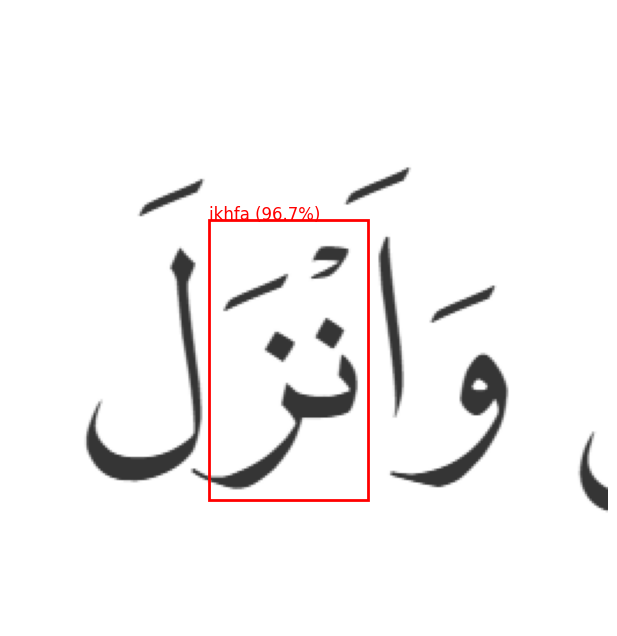

In [1]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
import torchvision.transforms.functional as F
import torchvision.ops as ops

import albumentations as A
from albumentations.pytorch import ToTensorV2

# === Path Model ===
MODEL_PATH = "TajwidModelCNNSSD.pth"
CLASS_NAMES = ['background', 'ikhfa', 'idgham', 'idzhar', 'iklab']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# === Load Model ===
model = ssdlite320_mobilenet_v3_large(pretrained=True)
model.head.classification_head.num_classes = len(CLASS_NAMES)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device), strict=False)
model = model.to(device)
model.eval()

# === Augmentasi Inference (mirip train val di Kaggle) ===
def get_infer_transform():
    return A.Compose([
        A.Resize(224, 224),
        ToTensorV2()
    ])

# === Fungsi Plot Prediksi dengan NMS ===
def plot_prediction(model, image_path, threshold=0.5, iou_thresh=0.3):
    model.eval()

    # Load and resize image
    original_img = Image.open(image_path).convert("RGB")
    orig_w, orig_h = original_img.size
    img_resized = original_img.resize((224, 224))
    img_tensor = F.to_tensor(img_resized).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)[0]

    # Simpan semua hasil awal
    all_boxes = outputs['boxes']
    all_labels = outputs['labels']
    all_scores = outputs['scores']

    final_boxes = []
    final_labels = []
    final_scores = []

    for class_idx in range(1, len(CLASS_NAMES)):
        cls_mask = all_labels == class_idx
        cls_boxes = all_boxes[cls_mask]
        cls_scores = all_scores[cls_mask]

        if cls_boxes.size(0) == 0:
            continue

        keep = ops.nms(cls_boxes, cls_scores, iou_thresh)
        for idx in keep:
            if cls_scores[idx] >= threshold:
                final_boxes.append(cls_boxes[idx])
                final_labels.append(class_idx)
                final_scores.append(cls_scores[idx])

    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    ax.imshow(original_img)

    scale_x = orig_w / 224
    scale_y = orig_h / 224

    if len(final_boxes) == 0:
        print("⚠️ Tidak ada prediksi valid yang ditemukan.")
    else:
        for box, label, score in zip(final_boxes, final_labels, final_scores):
            x1, y1, x2, y2 = box.cpu().numpy()
            x1 *= scale_x
            x2 *= scale_x
            y1 *= scale_y
            y2 *= scale_y

            ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                       fill=False, edgecolor='red', linewidth=2))
            ax.text(x1, y1, f"{CLASS_NAMES[label]} ({score*100:.1f}%)",
                    fontsize=12, color='red')

    plt.axis('off')
    plt.show()

# === Contoh penggunaan ===
plot_prediction(model, "./data_test/test_ikhfa3.png")
